<a href="https://colab.research.google.com/github/gaciuki2402/PID_Model/blob/main/PID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import sklearn
print(sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

1.5.0


**Loading Dataset**

In [ ]:
data =pd.read_csv("PID.csv")

In [ ]:
data.head()

,Patient ID,Age,Race,STDs/UTI History,IUD Use,Past Pelvic Pain,Imaging Results,Abnormal Discharge,Fever Onset,Irregular Periods,Dyspareunia,Dysuria,WBC Count,ESR,CRP Level,PID Diagnosis
0,P001,25,White,No,Yes,No,Normal (US),NaN,5/10/2025,No,Yes,No,Normal,Normal,Normal,Negative
1,P002,30,Black,Yes (2 years ago),No,Yes,Adnexal tenderness (US),Yellow discharge,4/20/2025,Yes,Yes,Yes,Elevated,Elevated,Slightly Elevated,Positive
2,P003,35,Asian,No,Yes,Yes,Pelvic adhesions (US),"Brown discharge, heavy bleeding",NaN,Irregular,Yes,Yes,High,High,High,Positive
3,P004,28,Hispanic,No,No,No,Normal (US),"White, clumpy discharge, itching",NaN,Regular,No,No,Normal,Normal,Normal,Negative
4,P005,33,Indigenous,Yes (current),Yes,No,Normal (US),NaN,NaN,Regular,No,No,Normal,Normal,Normal,Negative


**Data Cleaning **

In [ ]:
data.drop(columns=["Patient ID"], inplace=True)
data.drop(columns=["Race"], inplace=True)
data.drop(columns=["Fever Onset"],inplace=True)

In [ ]:
data.tail()

,Age,STDs/UTI History,IUD Use,Past Pelvic Pain,Imaging Results,Abnormal Discharge,Irregular Periods,Dyspareunia,Dysuria,WBC Count,ESR,CRP Level,PID Diagnosis
514,30,Chlamydia,Yes (3 years ago),Yes (3 years ago),Adnexal tenderness (US),"Yellowish discharge, itching",Irregular (30-35 days),Yes,Yes,Elevated,Elevated,Slightly Elevated,Positive
515,28,No,No,No,Normal (US),NaN,Regular (28 days),No,No,Normal,Normal,Normal,Negative
516,32,No,No,Yes (2 years ago),Pelvic adhesions (US),"Yellowish discharge, odor",Irregular (30-35 days),Yes,No,Elevated,Elevated,Slightly Elevated,Positive
517,25,Chlamydia,Yes (1 year ago),Yes (1 year ago),Adnexal tenderness (US),"Yellow discharge, pain",Irregular (30-35 days),Yes,Yes,Elevated,Elevated,Slightly Elevated,Positive
518,34,No,No,Yes (1 year ago),Normal (US),"Greyish discharge, itching",Regular (28 days),Yes,No,Elevated,Elevated,Slightly Elevated,Positive


**Define Features and Target**

In [ ]:
categorical_features = ["STDs/UTI History", "IUD Use", "Past Pelvic Pain", "Imaging Results", "Abnormal Discharge", "Irregular Periods", "Dyspareunia", "Dysuria","WBC Count", "ESR", "CRP Level",]
numerical_features = ["Age"]

# Target Mapping
data["PID Diagnosis"]= data["PID Diagnosis"].map({"Positive":1, "Negative":0})

x = data[categorical_features + numerical_features]
y = data["PID Diagnosis"]

In [ ]:
print(x)

      STDs/UTI History            IUD Use   Past Pelvic Pain  \
0                   No                Yes                 No   
1    Yes (2 years ago)                 No                Yes   
2                   No                Yes                Yes   
3                   No                 No                 No   
4        Yes (current)                Yes                 No   
..                 ...                ...                ...   
514          Chlamydia  Yes (3 years ago)  Yes (3 years ago)   
515                 No                 No                 No   
516                 No                 No  Yes (2 years ago)   
517          Chlamydia   Yes (1 year ago)   Yes (1 year ago)   
518                 No                 No   Yes (1 year ago)   

             Imaging Results                Abnormal Discharge  \
0                Normal (US)                               NaN   
1    Adnexal tenderness (US)                  Yellow discharge   
2      Pelvic adhesions (US)   Br

In [ ]:
print(y)

0      0
1      1
2      1
3      0
4      0
      ..
514    1
515    0
516    1
517    1
518    1
Name: PID Diagnosis, Length: 519, dtype: int64


**Define Goals and Metrics**

In [ ]:
# metrics comparison
metrics = {
    "accuracy":accuracy_score,
    "precision": lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=1),
    "recall": lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1),
    "f1": lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1),
    "roc_auc": lambda y_true, y_pred: roc_auc_score(y_true, y_pred)

}

**Split the Data**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

**Preprocessing Pipelines**

In [ ]:
# categorical data preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
print(categorical_transformer)
# This pipeline for categorical data first imputes missing values with the string 'missing'
# and then applies one-hot encoding to convert categorical features into numerical format.

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [ ]:
# Numerical Data Preprocessing
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
numerical_transformer
# This pipeline for numerical data first imputes missing values with the mean of the column
# and then scales the features to have a mean of 0
# and a standard deviation of 1.

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler())])

**Combine Preprocessing Steps**

In [ ]:
Preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)
# The ColumnTransformer combines both preprocessing pipelines,
# applying the appropriate transformations to the respective feature types.

**Evaluate Each Model**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

pipelines = {}
for model_name, model in models.items():
  pipeline = Pipeline(steps=[
      ("preprocessor", Preprocessor),
      ('classifier', model)
  ])
  pipelines[model_name] = pipeline

**Train the Models**

In [ ]:
# Train the model
results = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(x_train, y_train)
    results[model_name] = pipeline.score(x_test, y_test)

# print the results and compare
for model_name, score in results.items():
  print(f"Model: {model_name}, Score: {score}")

# convert results to Dataframe for easier comparison
results_df = pd.DataFrame(results, index=models.keys()).T
print(results_df)


Model: Logistic Regression, Score: 0.9903846153846154
Model: Decision Tree, Score: 0.9903846153846154
Model: Random Forest, Score: 0.9903846153846154
                     Logistic Regression  Decision Tree  Random Forest
Logistic Regression             0.990385       0.990385       0.990385
Decision Tree                   0.990385       0.990385       0.990385
Random Forest                   0.990385       0.990385       0.990385


**Visualize the Results**

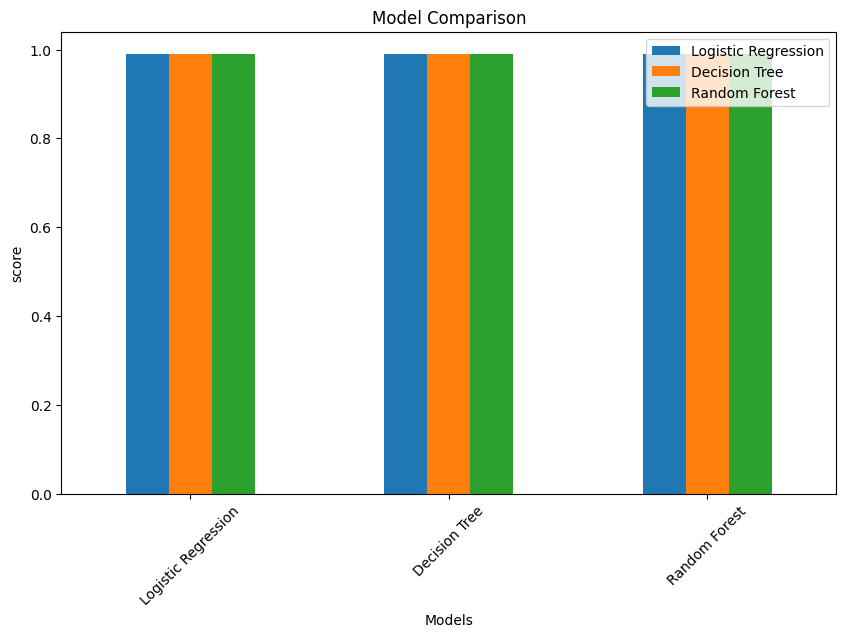

In [ ]:
# plotting comparison of metrics
results_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Comparison")
plt.ylabel("score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(loc="best")
plt.show()

In [ ]:
# function to input new data and predict
def predict_pid(age, stds_uti_history, iud_use, past_pelvic_pain, imaging_results, abnormal_discharge, irregular_periods, dyspareunia, dysuria, wbc_count, esr, crp_level):
  new_data = pd.DataFrame({
      'Age':[age],
      'STDs/UTI History': [stds_uti_history],
      'IUD Use': [iud_use],
      'Past Pelvic Pain': [past_pelvic_pain],
      'Imaging Results': [imaging_results],
      'Abnormal Discharge': [abnormal_discharge],
      'Irregular Periods': [irregular_periods],
      'Dyspareunia': [dyspareunia],
      'Dysuria': [dysuria],
      'WBC Count': [wbc_count],
      'ESR': [esr],
      'CRP Level': [crp_level]
  })
  return pipeline.predict(new_data)[0]
  # prediction
new_prediction = predict_pid(28,'No','Yes','No','Normal (US)','None','Regular','No','No','Normal','Normal','Normal')
print("Predicted PID Diagnosis (1=Positive, 0=Negative):", new_prediction)
if new_prediction == 0:
  print("PID Negative")
else:
  print("PID Positive")

Predicted PID Diagnosis (1=Positive, 0=Negative): 0
PID Negative


In [ ]:
! pip install joblib

In [ ]:
# Save the model
import joblib
model_path = 'PID_Model.joblib'
joblib.dump(pipeline, model_path,)

# Download the model file
# from google.colab import files
# files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load the model
loaded_model = joblib.load('PID_Model.joblib')

In [ ]:

# Define the prediction function
def predict_pid(age, stds_uti_history, iud_use, past_pelvic_pain, imaging_results, abnormal_discharge, irregular_periods, dyspareunia, dysuria, wbc_count, esr, crp_level):
    new_data = pd.DataFrame({
        'Age': [age],
        'STDs/UTI History': [stds_uti_history],
        'IUD Use': [iud_use],
        'Past Pelvic Pain': [past_pelvic_pain],
        'Imaging Results': [imaging_results],
        'Abnormal Discharge': [abnormal_discharge],
        'Irregular Periods': [irregular_periods],
        'Dyspareunia': [dyspareunia],
        'Dysuria': [dysuria],
        'WBC Count': [wbc_count],
        'ESR': [esr],
        'CRP Level': [crp_level]
    })

    prediction = loaded_model.predict(new_data)
    return prediction[0]

# Use the function to make a prediction
new_prediction = predict_pid(28, 'No', 'Yes', 'No', 'Normal (US)', 'None', 'Regular', 'No', 'No', 'Normal', 'Normal', 'Normal')

if new_prediction == 0:
    print("PID Negative")
else:
    print("PID Positive")


PID Negative
